In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("E:\\leonhardt\\mayi\\data\\train.csv")
df_test = pd.read_csv("E:\\leonhardt\\mayi\\data\\test_a.csv")

In [2]:
df_train = df_train[df_train["label"]!=-1]

In [3]:
train_set = df_train[df_train["date"]<=20171005]
eva_set = df_train[df_train["date"]>20171005]

In [4]:
train_set["id"].count()

483036

In [5]:
eva_set["id"].count()

506970

In [6]:
train_label = train_set["label"]
eva_label = eva_set["label"]

In [7]:
train_set.drop(["id", "label", "date"], axis=1, inplace=True)


D:\anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
eva_set.drop(["id", "label", "date"], axis=1, inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
def atec_metric(preds, train_data):
    labels = train_data.get_label()
    fpr,tpr,threshhold=roc_curve(labels, preds)
    return 'atec_metric', 0.4*tpr[fpr<=0.001][-1] + 0.3*tpr[fpr<=0.005][-1] + 0.3*tpr[fpr<=0.01][-1], True

In [11]:
import lightgbm as lgb
lgb_train=lgb.Dataset(train_set,train_label,free_raw_data=False)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 58,
          'early_stopping_round': 20
}

In [13]:
from sklearn.metrics import roc_curve
gbm=lgb.train(params, lgb_train, num_boost_round=1500, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=200)

[200]	valid_set's auc: 0.968521	valid_set's atec_metric: 0.495786
[400]	valid_set's auc: 0.972823	valid_set's atec_metric: 0.512102
[600]	valid_set's auc: 0.977813	valid_set's atec_metric: 0.517218
[800]	valid_set's auc: 0.979676	valid_set's atec_metric: 0.512165
[1000]	valid_set's auc: 0.980484	valid_set's atec_metric: 0.509979
[1200]	valid_set's auc: 0.981082	valid_set's atec_metric: 0.508142
[1400]	valid_set's auc: 0.981403	valid_set's atec_metric: 0.509156


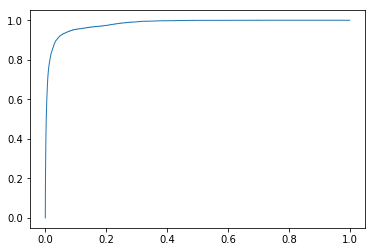

In [14]:
from scipy import interp  
from sklearn.metrics import auc
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  
all_tpr = []  

fpr, tpr, thresholds = roc_curve(eva_label, gbm.predict(eva_set))  
mean_tpr += interp(mean_fpr, fpr, tpr)          #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数  
mean_tpr[0] = 0.0                               #初始处为0  
roc_auc = auc(fpr, tpr)  
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % ( roc_auc))

In [16]:
df_test.drop(["id", "date"], axis=1, inplace=True)

In [17]:
y_pred = gbm.predict(df_test)

In [19]:
y_pred.min()

6.47019204587445e-06

In [21]:
y_pred.max()

0.9351078584977607

In [22]:
np.savetxt(os.getcwd()+"/prediction/lgb_half_1.txt", y_pred, delimiter=',')

In [24]:
train_1 = train_set[train_label==1]
trian_label_1 = train_label[train_label==1]
train_0 = train_set[train_label==0]
trian_label_0 = train_label[train_label==0]

In [25]:
train_stack = []
train_stack_label = []
for i in range(10):
    if i == 0:
        train_stack = np.vstack((train_1, train_0))
        train_stack_label = np.hstack((trian_label_1, trian_label_0))
    else:
        train_stack = np.vstack((train_stack, train_1))
        train_stack_label = np.hstack((train_stack_label, trian_label_1))

In [26]:
from sklearn.utils import shuffle
train_fil, label_fil = shuffle(train_stack, train_stack_label)

In [29]:
train_fil.shape

(535317, 297)

In [38]:
lgb_train=lgb.Dataset(train_fil,label_fil,free_raw_data=False)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 58
}

In [39]:
gbm2=lgb.train(params, lgb_train, num_boost_round=500, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=200)

[200]	valid_set's auc: 0.975551	valid_set's atec_metric: 0.479027
[400]	valid_set's auc: 0.979659	valid_set's atec_metric: 0.488579


In [40]:
y_pred2 = gbm2.predict(df_test)

In [41]:
np.savetxt(os.getcwd()+"/prediction/lgb_half_stack500.txt", y_pred2, delimiter=',')

In [2]:
for num in range(10, 380, 30):
    print("{0} score is {1}".format(num, 1))

10 score is 1
40 score is 1
70 score is 1
100 score is 1
130 score is 1
160 score is 1
190 score is 1
220 score is 1
250 score is 1
280 score is 1
310 score is 1
340 score is 1
370 score is 1
